# Create a `dataset_id`-level split for cellxgene mouse data

The idea is to create a permanent split for cellxgene based on dataset_ids because validating on unseen datasets is a harder task.

Because the datasets are heterogeneous we want the training set to have seen all the celltypes. We also want the validation set to cover as many cell types as possible, without breaking the first rule.

One could imagine different splits that try and optimize the problem differently. This shows how to implement such logic for one case. The code can be modified to work with any csv file that has a split column.

Please note that as of March 2024, the TileDB-SOMA database backend does not work on CCC login nodes. In order to run this notebook, you must use a compute node. GPU is not necessary so a simple compute node like `jbsub -mem 32g -cores 8 -q x86_1h -interactive bash` would work.

If you only want to see the data, you can run this notebook locally (tested on MacOS with brew python) by setting `uri=None`.

## Loading dataset and exploration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tiledbsoma

In [2]:
uri='/proj/bmfm/omics/data/scRNA/cellxgene/2025-01-30/soma'
census = tiledbsoma.open(uri=uri)

experiment = census["census_data"]["mus_musculus"]

To view the columns that are available for us to use for filtering the data using `value_filter` and/or to define a split, we'll read a single sample coalesce to pandas and print out the columns.  To learn more about using these operations, check out the notebook https://cloud.tiledb.com/notebooks/details/TileDB-Inc/a41fdf2c-6e69-415b-8598-1829b1998909/preview

In [3]:
dataset_columns = (
    experiment.obs.read(
        coords=[0],
        value_filter="is_primary_data==True and nnz > 2",
    )
    .concat()
    .to_pandas()
    .columns
)
dataset_columns

Index(['soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id',
       'cell_type', 'cell_type_ontology_term_id', 'development_stage',
       'development_stage_ontology_term_id', 'disease',
       'disease_ontology_term_id', 'donor_id', 'is_primary_data',
       'observation_joinid', 'self_reported_ethnicity',
       'self_reported_ethnicity_ontology_term_id', 'sex',
       'sex_ontology_term_id', 'suspension_type', 'tissue',
       'tissue_ontology_term_id', 'tissue_type', 'tissue_general',
       'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz',
       'raw_variance_nnz', 'n_measured_vars'],
      dtype='object')

The full documentation for these columns can be found in CellXGene's schema document
https://github.com/chanzuckerberg/single-cell-curation/blob/main/schema/3.0.0/schema.md

Let's see how many samples we have in this version of the dataset (`is_primary_data==True` removes duplicates)

In [4]:
samples_df = (
    experiment.obs.read(
        value_filter="is_primary_data==True",
        column_names=[
            "dataset_id",
            "assay",
            "suspension_type",
            "cell_type",
            "donor_id",
            "tissue",
            "tissue_general",
            "nnz",
        ],
    )
    .concat()
    .to_pandas()
)

In [5]:
samples_df.shape

(17633669, 9)

In [6]:
(samples_df.donor_id.value_counts() > 100)

donor_id
embryo_74      True
pooled         True
embryo_73      True
embryo_53      True
embryo_41      True
              ...  
280708        False
353938        False
228852        False
270079        False
musAd004n5    False
Name: count, Length: 1439, dtype: bool

It's worth noting that we have a variety of different assays here, and we may need to make use of this information at some point:

In [7]:
samples_df[["assay", "dataset_id"]].drop_duplicates().groupby(
    "assay"
).count().squeeze().sort_values()

/tmp/ipykernel_1280061/2738154594.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  samples_df[["assay", "dataset_id"]].drop_duplicates().groupby(


assay
10x 3' transcription profiling               1
10x 5' v2                                    1
BD Rhapsody Whole Transcriptome Analysis     1
DroNc-seq                                    1
Smart-seq                                    1
sci-RNA-seq3                                 1
10x 3' v1                                    2
Smart-seq3                                   2
inDrop                                       2
10x 5' v1                                    3
Smart-seq v4                                 3
Smart-seq2                                   3
Drop-seq                                     5
10x 3' v2                                   19
10x 3' v3                                   29
Name: dataset_id, dtype: int64

Not all datasets are the same size, not by a longshot. We actually have 6 orders of magnitude in dataset size. Yikes.

/tmp/ipykernel_1280061/1968566613.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  samples_df.groupby("dataset_id").count().iloc[:, 0].hist(bins=np.logspace(0, 7, 20))


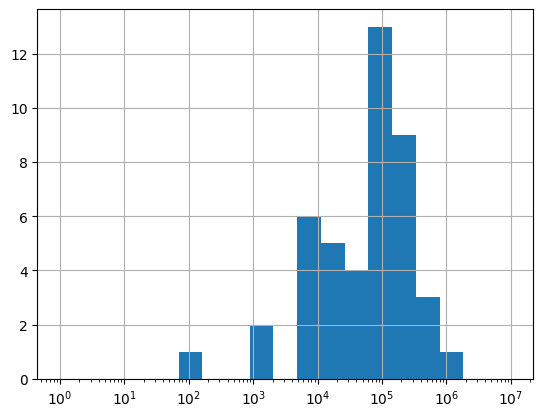

In [8]:
samples_df.groupby("dataset_id").count().iloc[:, 0].hist(bins=np.logspace(0, 7, 20))
plt.xscale("log")

Let's look at the non-zero counts. How many samples have more than a certain number of non-zero reads? This is critically important for the purpose of context windows. Let's start by just plotting all the counts:

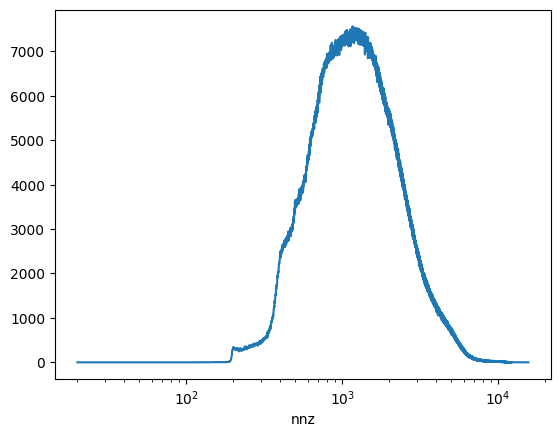

In [9]:
nnz_counts = samples_df.nnz.value_counts()
nnz_counts.sort_index().plot()
plt.xscale("log")

(14.335404743666386, 15611)

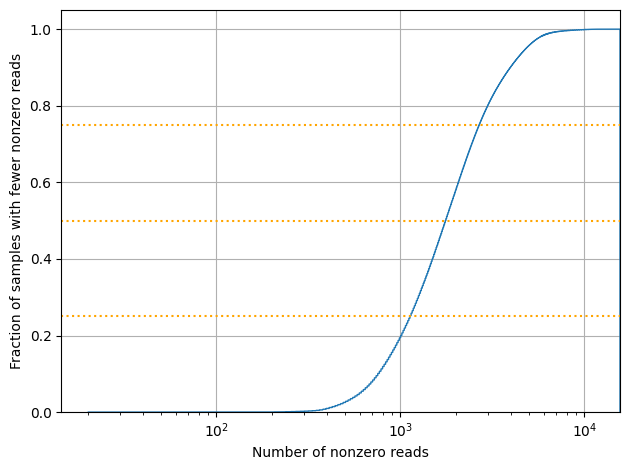

In [10]:
_ = plt.hist(samples_df.nnz, bins=1000, density=True, cumulative=True, histtype="step")
for h in [0.25, 0.5, 0.75]:
    plt.axhline(h, ls=":", color="orange")
plt.xscale("log")
plt.grid("on")
plt.xlabel("Number of nonzero reads")
plt.ylabel("Fraction of samples with fewer nonzero reads")
plt.tight_layout()
plt.xlim(xmax=samples_df.nnz.max())

In [11]:
q = np.arange(0, 1.01, 0.05)
qvals = np.quantile(samples_df.nnz, q)
pd.Series(qvals, index=q, dtype=int)

0.00       20
0.05      612
0.10      766
0.15      894
0.20     1017
0.25     1138
0.30     1258
0.35     1378
0.40     1502
0.45     1630
0.50     1766
0.55     1913
0.60     2072
0.65     2248
0.70     2448
0.75     2687
0.80     2987
0.85     3391
0.90     3964
0.95     4830
1.00    15611
dtype: int64

From here we see that less than 15% of samples have only 512 nonzero reads! The good news is that getting from 1024 to 2048 covers a comfortable majority of all samples. Pushing above 4096 is definitely diminishing returns in terms of nonzeros.

## Create dataset x cell type dataframe

We want to be able to split the full CellxGene dataset by `dataset_id`, ie to use some component datasets for training and others for validation. Furthermore, since cell-types are particularly important we want to be sure that we have a good split of cell-types and not end up doing the entire training without encountering certain cell-types OR to run validation without checking certain cell-types. 

So we will create a dataframe that lists how many of every cell type we have for every dataset and use that for creating our split.

In [14]:
def rowcolsort(df, ascending=False):
    row_sums = (df > 0).sum(axis=1)
    col_sums = (df > 0).sum(axis=0)
    return df.loc[
        row_sums.sort_values(ascending=ascending).index,
        col_sums.sort_values(ascending=ascending).index,
    ]


def make_dataset_celltype_df(samples_df, use_rowcolsort=True):
    dataset_df = samples_df.groupby(["dataset_id", "cell_type"]).count()
    dataset_df = dataset_df.iloc[:, 0].rename("sample_count").reset_index()
    pivoted_df = dataset_df.pivot_table(
        index=["dataset_id"], columns="cell_type", values="sample_count"
    )
    dataset_celltype_df = (
        pivoted_df.fillna(0).reset_index()
        .applymap(lambda x: int(x) if isinstance(x, float) else x)
        .set_index("dataset_id")
    )
    if use_rowcolsort:
        dataset_celltype_df = rowcolsort(dataset_celltype_df, ascending=False)
    return dataset_celltype_df

In [15]:
dataset_celltype_df = make_dataset_celltype_df(samples_df)

/tmp/ipykernel_1280061/2277073086.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset_df = samples_df.groupby(["dataset_id", "cell_type"]).count()
/tmp/ipykernel_1280061/2277073086.py:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted_df = dataset_df.pivot_table(
/tmp/ipykernel_1280061/2277073086.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: int(x) if isinstance(x, float) else x)


## Create celltype split

The logic behind this split is to try and maximize the samples in train while ensuring that every cell-type has at least one sample in validation. Since we are splitting by dataset, that means taking each dataset and assigning it to either validation or train based on the following check. If the dataset has cell-types which have never been seen before, assign it to train. If the dataset has cell-types which have been seen in train but not in validation, assign it to validation. If all of the dataset's cell-types have been seen in train and in validation, assign it to train.

The logic of the sorting is to start on the datasets with fewest celltypes and samples so that we can get validation taken care of without giving up too many samples from train.

One could definitely propose a more sophisticated process for assigning datasets which would optimize the twin objectives of maximal volume in training and maximal breadth in validation. But we didn't invest the time in that at this point. This split seems good enough and there's no such thing as a "perfect" split. The code base is open to future, superior splits.

In [16]:
def add_cell_type_split_to_dataframe(dataset_celltype_df):
    train_cell_types = set()
    validation_cell_types = set()
    train_datasets = set()
    validation_datasets = set()
    for dataset_id, row in dataset_celltype_df.iterrows():
        cell_types = set(row[row > 0].index.to_list())
        if not cell_types.issubset(validation_cell_types) and cell_types.issubset(
            train_cell_types
        ):
            validation_cell_types.update(cell_types)
            validation_datasets.add(dataset_id)
        else:
            train_cell_types.update(cell_types)
            train_datasets.add(dataset_id)
    dataset_celltype_df.loc[list(train_datasets), "split"] = "train"
    dataset_celltype_df.loc[list(validation_datasets), "split"] = "dev"
    return dataset_celltype_df

In [17]:
dataset_celltype_df = add_cell_type_split_to_dataframe(dataset_celltype_df)

Let's check how many samples we had in each split:

In [18]:
split_counts = dataset_celltype_df.groupby("split").sum().sum(axis=1)
split_counts

split
dev       1566219
train    16067450
dtype: int64

In [19]:
print(
    f"Fractions of total cells in splits:\n\t train: {split_counts['train'] / split_counts.sum()} \n\t dev: {split_counts['dev'] / split_counts.sum()}"
)

Fractions of total cells in splits:
	 train: 0.911180197382632 
	 dev: 0.08881980261736795


This is approximately what we would like, and it's doubtful we could do much better in terms of the split's effect on model quality. 

It is also instructive to look at the number of datasets in each split:

In [20]:
dataset_celltype_df.split.value_counts()

split
train    155
dev        6
Name: count, dtype: int64

Broadly speaking this is a good split. It avoids the problem of using samples that are too close to each other in train and validation, it guarantees full cell-type coverage in train, and it approximately maximizes cell-type coverage in validation. 

We will save it, and it will become our default split:

In [21]:
dataset_celltype_df.to_csv("celltypes_split_mouse.csv")

## Deeper dive into split counts

If we want to dive in a little deeper, we can ask how many of every cell type there are in each split and in each dataset. Ideally, we would have more datasets and more samples of every cell-type in train than in dev. We see that that is almost, but not quite the case.

In [22]:
split = dataset_celltype_df.pop("split")
split_dataset_count_df = (dataset_celltype_df > 0).groupby(split).sum().T
split_cell_count_df = dataset_celltype_df.groupby(split).sum().T
dataset_celltype_df = dataset_celltype_df.assign(split=split)
pd.concat([split_dataset_count_df, split_cell_count_df], axis=1)

split,dev,train,dev,train
cell_type,,,,
endothelial cell,4,22,4140,200148
pericyte,3,18,1252,33737
fibroblast,0,16,0,723543
macrophage,0,16,0,122980
B cell,0,15,0,121770
...,...,...,...,...
"effector CD8-positive, alpha-beta T cell",0,1,0,129
mesodermal cell,0,1,0,1463106
kidney loop of Henle thick ascending limb epithelial cell,0,1,0,1554


In [23]:
samples_df.suspension_type.value_counts()

suspension_type
nucleus    13326672
cell        4306997
Name: count, dtype: int64

In [24]:
genes_df = (
    experiment.ms["RNA"].var.read(    )
    .concat()
    .to_pandas()
)

In [25]:
genes_df

,soma_joinid,feature_id,feature_name,feature_type,feature_length,nnz,n_measured_obs
0,0,ENSMUSG00000021124,Vti1b,protein_coding,841,7020258,42776863
1,1,ENSMUSG00000039377,Hlx,protein_coding,1495,481426,42641734
2,2,ENSMUSG00000085604,Dhx58os,lncRNA,1594,117050,40553677
3,3,ENSMUSG00000085125,Gm16070,lncRNA,2146,2280673,41179548
4,4,ENSMUSG00000029439,Sfswap,protein_coding,692,17553003,42776863
...,...,...,...,...,...,...,...
52478,52478,ENSMUSG00002076971,Snord100,snoRNA,74,3653,73347
52479,52479,ENSMUSG00002076818,Snord14e,snoRNA,90,3579,73347
52480,52480,ENSMUSG00002076766,Snord33,snoRNA,84,612,73347
52481,52481,ENSMUSG00000118645,Gm55062,lncRNA,480,0,301796
